# SwellSight Data Loading and Utilities (Standalone)

This notebook contains all data loading utilities, dataset classes, and helper functions for the SwellSight project.
**This is a standalone version that includes all necessary code and doesn't require external files.**

## Components
- Utility functions (seed setting, file I/O)
- Dataset class for loading wave images and labels
- Vocabulary building for classification tasks
- Data transforms for training and inference

In [1]:
# Install required packages if not available
import subprocess
import sys

def install_if_missing(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install required packages
required_packages = ['torch', 'torchvision', 'pillow', 'matplotlib', 'numpy']
for package in required_packages:
    install_if_missing(package)

print("✓ All required packages are available")

Installing pillow...
✓ All required packages are available


In [2]:
import os
import json
import random
from typing import List, Dict, Any, Tuple

import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torch.version.__version__ if hasattr(torch.version, '__version__') else 'N/A'}")

PyTorch version: 2.9.1
Torchvision version: 2.9.1


## Utility Functions

In [3]:
def set_seed(seed: int) -> None:
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For deterministic behavior (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def ensure_dir(path: str) -> None:
    """Create directory if it doesn't exist."""
    if path:  # Only create if path is not empty
        os.makedirs(path, exist_ok=True)


def read_jsonl(path: str) -> List[Dict[str, Any]]:
    """Read JSONL file and return list of records."""
    items = []
    try:
        with open(path, "r", encoding="utf-8") as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if line:  # Skip empty lines
                    try:
                        items.append(json.loads(line))
                    except json.JSONDecodeError as e:
                        print(f"Warning: Invalid JSON on line {line_num}: {e}")
    except FileNotFoundError:
        print(f"Warning: File not found: {path}")
    return items


def write_jsonl(items: List[Dict[str, Any]], path: str) -> None:
    """Write list of records to JSONL file."""
    ensure_dir(os.path.dirname(path))
    with open(path, "w", encoding="utf-8") as f:
        for r in items:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")


def load_json(path: str) -> Dict[str, Any]:
    """Load JSON file."""
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Warning: File not found: {path}")
        return {}
    except json.JSONDecodeError as e:
        print(f"Warning: Invalid JSON in {path}: {e}")
        return {}


def save_json(data: Dict[str, Any], path: str) -> None:
    """Save data to JSON file."""
    ensure_dir(os.path.dirname(path))
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)

print("✓ Utility functions defined")

✓ Utility functions defined


## Data Transforms

In [4]:
def build_transforms(train: bool, image_size: int = 224):
    """Build data transforms for training or inference.
    
    Args:
        train: If True, applies training augmentations
        image_size: Target image size (square)
        
    Returns:
        torchvision.transforms.Compose object
    """
    if train:
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(
                brightness=0.15, 
                contrast=0.15, 
                saturation=0.10, 
                hue=0.03
            ),
            transforms.RandomApply([
                transforms.GaussianBlur(kernel_size=3)
            ], p=0.15),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet means
                std=[0.229, 0.224, 0.225]    # ImageNet stds
            ),
        ])

    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])


def build_infer_transform(image_size: int):
    """Build transform for single image inference."""
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

print("✓ Transform functions defined")

✓ Transform functions defined


## Dataset and Vocabulary Functions

In [5]:
def confidence_to_weight(conf: str) -> float:
    """Convert confidence string to sample weight.
    
    Args:
        conf: Confidence level ('high', 'medium', 'low')
        
    Returns:
        Weight value between 0 and 1
    """
    conf = (conf or "medium").lower().strip()
    confidence_weights = {
        "high": 1.0,
        "medium": 0.7,
        "low": 0.4
    }
    return confidence_weights.get(conf, 0.7)  # Default to medium


def build_vocabs(items: List[Dict[str, Any]]) -> Tuple[Dict[str, int], Dict[str, int]]:
    """Build vocabularies for wave types and directions.
    
    Args:
        items: List of dataset records with 'wave_type' and 'direction' fields
        
    Returns:
        Tuple of (wave_type_to_id, direction_to_id) dictionaries
    """
    wave_types = sorted({x["wave_type"] for x in items if "wave_type" in x})
    directions = sorted({x["direction"] for x in items if "direction" in x})
    
    wave_type_to_id = {k: i for i, k in enumerate(wave_types)}
    direction_to_id = {k: i for i, k in enumerate(directions)}
    
    return wave_type_to_id, direction_to_id


def get_default_vocabs() -> Tuple[Dict[str, int], Dict[str, int]]:
    """Get default SwellSight vocabularies."""
    wave_types = ["beach_break", "reef_break", "point_break", "closeout", "a_frame"]
    directions = ["left", "right", "both"]
    
    wave_type_to_id = {wt: i for i, wt in enumerate(wave_types)}
    direction_to_id = {d: i for i, d in enumerate(directions)}
    
    return wave_type_to_id, direction_to_id

print("✓ Vocabulary functions defined")

✓ Vocabulary functions defined


In [6]:
class SwellSightDataset(Dataset):
    """Dataset class for SwellSight wave analysis.
    
    Loads images and labels from JSONL index files.
    Supports both real and synthetic data.
    """
    
    def __init__(
        self,
        index_jsonl: str,
        transform=None,
        wave_type_to_id: Dict[str, int] = None,
        direction_to_id: Dict[str, int] = None,
    ):
        """
        Args:
            index_jsonl: Path to JSONL file with dataset records
            transform: Optional torchvision transform
            wave_type_to_id: Wave type vocabulary (auto-built if None)
            direction_to_id: Direction vocabulary (auto-built if None)
        """
        self.items = read_jsonl(index_jsonl)
        self.transform = transform
        
        if not self.items:
            print(f"Warning: No items loaded from {index_jsonl}")
            # Create dummy data for demonstration
            self.items = self._create_dummy_data()

        if wave_type_to_id is None or direction_to_id is None:
            self.wave_type_to_id, self.direction_to_id = build_vocabs(self.items)
        else:
            self.wave_type_to_id = wave_type_to_id
            self.direction_to_id = direction_to_id
            
        print(f"Dataset loaded: {len(self.items)} samples")
        print(f"Wave types: {list(self.wave_type_to_id.keys())}")
        print(f"Directions: {list(self.direction_to_id.keys())}")

    def _create_dummy_data(self, n_samples: int = 50) -> List[Dict[str, Any]]:
        """Create dummy data for demonstration when real data is not available."""
        print("Creating dummy data for demonstration...")
        
        wave_types = ["beach_break", "reef_break", "point_break", "closeout", "a_frame"]
        directions = ["left", "right", "both"]
        
        dummy_items = []
        for i in range(n_samples):
            dummy_items.append({
                "image_path": f"dummy_image_{i:03d}.jpg",
                "height_meters": float(np.random.uniform(0.5, 2.5)),
                "wave_type": np.random.choice(wave_types),
                "direction": np.random.choice(directions),
                "confidence": np.random.choice(["high", "medium", "low"]),
                "notes": f"Dummy sample {i}",
                "source": "dummy"
            })
        
        return dummy_items

    def __len__(self) -> int:
        return len(self.items)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        r = self.items[idx]
        
        # Load image or create dummy image
        try:
            if os.path.exists(r["image_path"]):
                img = Image.open(r["image_path"]).convert("RGB")
            else:
                # Create dummy image if file doesn't exist
                img = self._create_dummy_image()
        except Exception as e:
            print(f"Warning: Could not load {r['image_path']}: {e}")
            img = self._create_dummy_image()

        if self.transform is not None:
            img = self.transform(img)

        # Convert labels to tensors
        height = torch.tensor([float(r["height_meters"])], dtype=torch.float32)
        
        # Handle missing wave types/directions gracefully
        wave_type_str = r.get("wave_type", "beach_break")
        direction_str = r.get("direction", "both")
        
        # Use default if not in vocabulary
        wave_type_id = self.wave_type_to_id.get(wave_type_str, 0)
        direction_id = self.direction_to_id.get(direction_str, 0)
        
        wave_type = torch.tensor(wave_type_id, dtype=torch.long)
        direction = torch.tensor(direction_id, dtype=torch.long)
        
        weight = torch.tensor(
            [confidence_to_weight(r.get("confidence", "medium"))], 
            dtype=torch.float32
        )

        return {
            "image": img,
            "height": height,
            "wave_type": wave_type,
            "direction": direction,
            "weight": weight,
            "meta": r
        }
    
    def _create_dummy_image(self, size: Tuple[int, int] = (224, 224)) -> Image.Image:
        """Create a dummy image for demonstration."""
        # Create a simple gradient that looks like water
        img_array = np.zeros((*size, 3), dtype=np.uint8)
        
        # Create blue gradient
        for y in range(size[1]):
            intensity = int(100 + 100 * (y / size[1]))
            img_array[y, :, 2] = intensity  # Blue channel
            img_array[y, :, 1] = intensity // 2  # Green channel
        
        return Image.fromarray(img_array, 'RGB')

print("✓ SwellSightDataset class defined")

✓ SwellSightDataset class defined


## Example Usage and Testing

In [7]:
# Set seed for reproducibility
set_seed(42)
print("✓ Random seed set to 42")

# Example of creating transforms
train_transform = build_transforms(train=True, image_size=224)
val_transform = build_transforms(train=False, image_size=224)

print("\n📸 Training transforms:")
for i, transform in enumerate(train_transform.transforms):
    print(f"  {i+1}. {transform.__class__.__name__}")

print("\n📸 Validation transforms:")
for i, transform in enumerate(val_transform.transforms):
    print(f"  {i+1}. {transform.__class__.__name__}")

✓ Random seed set to 42

📸 Training transforms:
  1. Resize
  2. RandomHorizontalFlip
  3. ColorJitter
  4. RandomApply
  5. ToTensor
  6. Normalize

📸 Validation transforms:
  1. Resize
  2. ToTensor
  3. Normalize


In [8]:
# Test dataset creation with dummy data
print("Testing dataset creation...")

# This will create dummy data since the file doesn't exist
dataset = SwellSightDataset(
    "nonexistent_file.jsonl",  # This will trigger dummy data creation
    transform=train_transform
)

print(f"\n✓ Dataset created with {len(dataset)} samples")
print(f"Wave type vocabulary: {dataset.wave_type_to_id}")
print(f"Direction vocabulary: {dataset.direction_to_id}")

Testing dataset creation...
Creating dummy data for demonstration...
Dataset loaded: 50 samples
Wave types: [np.str_('a_frame'), np.str_('beach_break'), np.str_('closeout'), np.str_('point_break'), np.str_('reef_break')]
Directions: [np.str_('both'), np.str_('left'), np.str_('right')]

✓ Dataset created with 50 samples
Wave type vocabulary: {np.str_('a_frame'): 0, np.str_('beach_break'): 1, np.str_('closeout'): 2, np.str_('point_break'): 3, np.str_('reef_break'): 4}
Direction vocabulary: {np.str_('both'): 0, np.str_('left'): 1, np.str_('right'): 2}


In [9]:
# Test loading a sample
print("Testing sample loading...")

sample = dataset[0]
print(f"\n📊 First sample:")
print(f"Image shape: {sample['image'].shape}")
print(f"Height: {sample['height'].item():.2f}m")
print(f"Wave type ID: {sample['wave_type'].item()}")
print(f"Direction ID: {sample['direction'].item()}")
print(f"Weight: {sample['weight'].item():.2f}")
print(f"Metadata: {sample['meta']}")

# Convert IDs back to labels
id_to_wave_type = {v: k for k, v in dataset.wave_type_to_id.items()}
id_to_direction = {v: k for k, v in dataset.direction_to_id.items()}

wave_type_label = id_to_wave_type[sample['wave_type'].item()]
direction_label = id_to_direction[sample['direction'].item()]

print(f"\n🏷️ Decoded labels:")
print(f"Wave type: {wave_type_label}")
print(f"Direction: {direction_label}")

Testing sample loading...

📊 First sample:
Image shape: torch.Size([3, 224, 224])
Height: 1.25m
Wave type ID: 0
Direction ID: 0
Weight: 0.40
Metadata: {'image_path': 'dummy_image_000.jpg', 'height_meters': 1.249080237694725, 'wave_type': np.str_('a_frame'), 'direction': np.str_('both'), 'confidence': np.str_('low'), 'notes': 'Dummy sample 0', 'source': 'dummy'}

🏷️ Decoded labels:
Wave type: a_frame
Direction: both


## Visualization Functions

In [10]:
def visualize_sample(dataset, idx: int = 0, figsize: Tuple[int, int] = (10, 6)):
    """Visualize a dataset sample."""
    sample = dataset[idx]
    
    # Convert tensor back to PIL image for visualization
    img_tensor = sample['image']
    
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_denorm = img_tensor * std + mean
    img_denorm = torch.clamp(img_denorm, 0, 1)
    
    # Convert to numpy for matplotlib
    img_np = img_denorm.permute(1, 2, 0).numpy()
    
    # Get labels
    id_to_wave_type = {v: k for k, v in dataset.wave_type_to_id.items()}
    id_to_direction = {v: k for k, v in dataset.direction_to_id.items()}
    
    wave_type = id_to_wave_type[sample['wave_type'].item()]
    direction = id_to_direction[sample['direction'].item()]
    height = sample['height'].item()
    weight = sample['weight'].item()
    
    # Plot
    plt.figure(figsize=figsize)
    plt.imshow(img_np)
    plt.title(
        f"Sample {idx}\n"
        f"Height: {height:.2f}m | Type: {wave_type} | Direction: {direction}\n"
        f"Weight: {weight:.2f} | Shape: {img_tensor.shape}"
    )
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def visualize_batch_samples(dataset, n_samples: int = 6, figsize: Tuple[int, int] = (15, 10)):
    """Visualize multiple samples from the dataset."""
    n_samples = min(n_samples, len(dataset))
    
    cols = 3
    rows = (n_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    # Get label mappings
    id_to_wave_type = {v: k for k, v in dataset.wave_type_to_id.items()}
    id_to_direction = {v: k for k, v in dataset.direction_to_id.items()}
    
    for i in range(n_samples):
        row, col = i // cols, i % cols
        
        sample = dataset[i]
        
        # Denormalize image
        img_tensor = sample['image']
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_denorm = img_tensor * std + mean
        img_denorm = torch.clamp(img_denorm, 0, 1)
        img_np = img_denorm.permute(1, 2, 0).numpy()
        
        # Get labels
        wave_type = id_to_wave_type[sample['wave_type'].item()]
        direction = id_to_direction[sample['direction'].item()]
        height = sample['height'].item()
        
        # Plot
        axes[row, col].imshow(img_np)
        axes[row, col].set_title(
            f"Sample {i}\n{height:.1f}m {wave_type}\n{direction}",
            fontsize=10
        )
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for i in range(n_samples, rows * cols):
        row, col = i // cols, i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✓ Visualization functions defined")

✓ Visualization functions defined


Visualizing dataset samples...


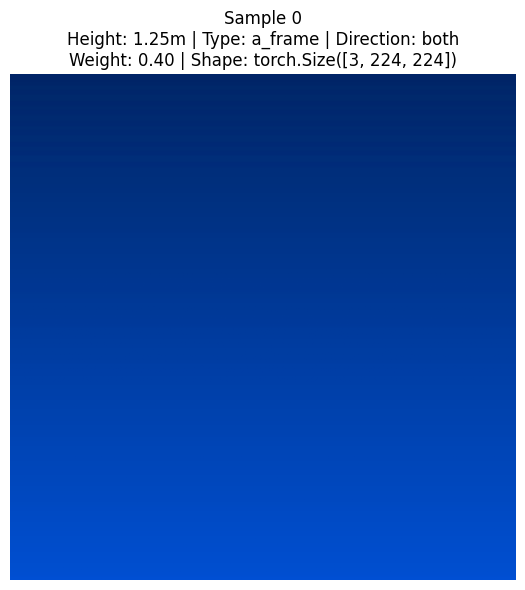

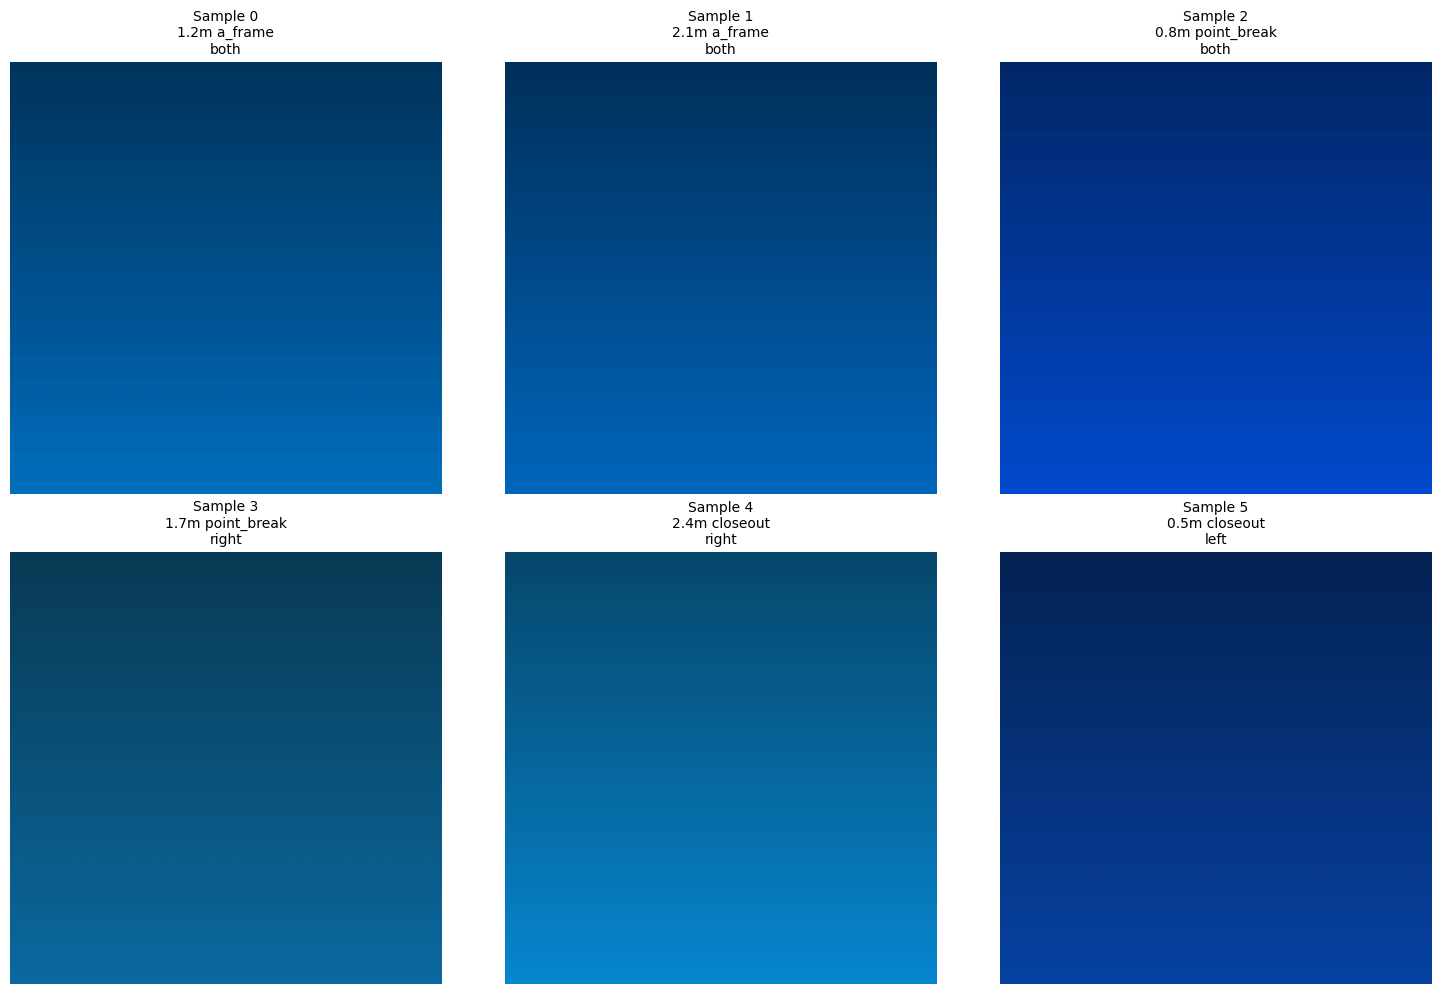

In [11]:
# Visualize some samples
print("Visualizing dataset samples...")

# Single sample
visualize_sample(dataset, idx=0)

# Multiple samples
visualize_batch_samples(dataset, n_samples=6)

## Dataset Statistics

In [12]:
def analyze_dataset_statistics(dataset):
    """Analyze and display dataset statistics."""
    print("Dataset Statistics Analysis:")
    print("=" * 40)
    
    # Collect all labels
    heights = []
    wave_types = []
    directions = []
    weights = []
    
    id_to_wave_type = {v: k for k, v in dataset.wave_type_to_id.items()}
    id_to_direction = {v: k for k, v in dataset.direction_to_id.items()}
    
    for i in range(len(dataset)):
        sample = dataset[i]
        heights.append(sample['height'].item())
        wave_types.append(id_to_wave_type[sample['wave_type'].item()])
        directions.append(id_to_direction[sample['direction'].item()])
        weights.append(sample['weight'].item())
    
    heights = np.array(heights)
    
    # Height statistics
    print(f"\n📏 Height Statistics:")
    print(f"  Count: {len(heights)}")
    print(f"  Mean: {heights.mean():.3f}m")
    print(f"  Std: {heights.std():.3f}m")
    print(f"  Min: {heights.min():.3f}m")
    print(f"  Max: {heights.max():.3f}m")
    print(f"  Median: {np.median(heights):.3f}m")
    
    # Wave type distribution
    from collections import Counter
    wt_counts = Counter(wave_types)
    print(f"\n🌊 Wave Type Distribution:")
    for wt, count in wt_counts.most_common():
        percentage = count / len(wave_types) * 100
        print(f"  {wt}: {count} ({percentage:.1f}%)")
    
    # Direction distribution
    dir_counts = Counter(directions)
    print(f"\n🧭 Direction Distribution:")
    for direction, count in dir_counts.most_common():
        percentage = count / len(directions) * 100
        print(f"  {direction}: {count} ({percentage:.1f}%)")
    
    # Weight distribution
    weights = np.array(weights)
    print(f"\n⚖️ Weight Statistics:")
    print(f"  Mean: {weights.mean():.3f}")
    print(f"  Std: {weights.std():.3f}")
    print(f"  Unique values: {np.unique(weights)}")
    
    return {
        'heights': heights,
        'wave_types': wave_types,
        'directions': directions,
        'weights': weights,
        'wave_type_counts': dict(wt_counts),
        'direction_counts': dict(dir_counts)
    }

# Analyze the dataset
stats = analyze_dataset_statistics(dataset)

Dataset Statistics Analysis:

📏 Height Statistics:
  Count: 50
  Mean: 1.467m
  Std: 0.613m
  Min: 0.502m
  Max: 2.495m
  Median: 1.407m

🌊 Wave Type Distribution:
  point_break: 11 (22.0%)
  beach_break: 11 (22.0%)
  closeout: 10 (20.0%)
  a_frame: 9 (18.0%)
  reef_break: 9 (18.0%)

🧭 Direction Distribution:
  left: 19 (38.0%)
  both: 17 (34.0%)
  right: 14 (28.0%)

⚖️ Weight Statistics:
  Mean: 0.754
  Std: 0.230
  Unique values: [0.40000001 0.69999999 1.        ]


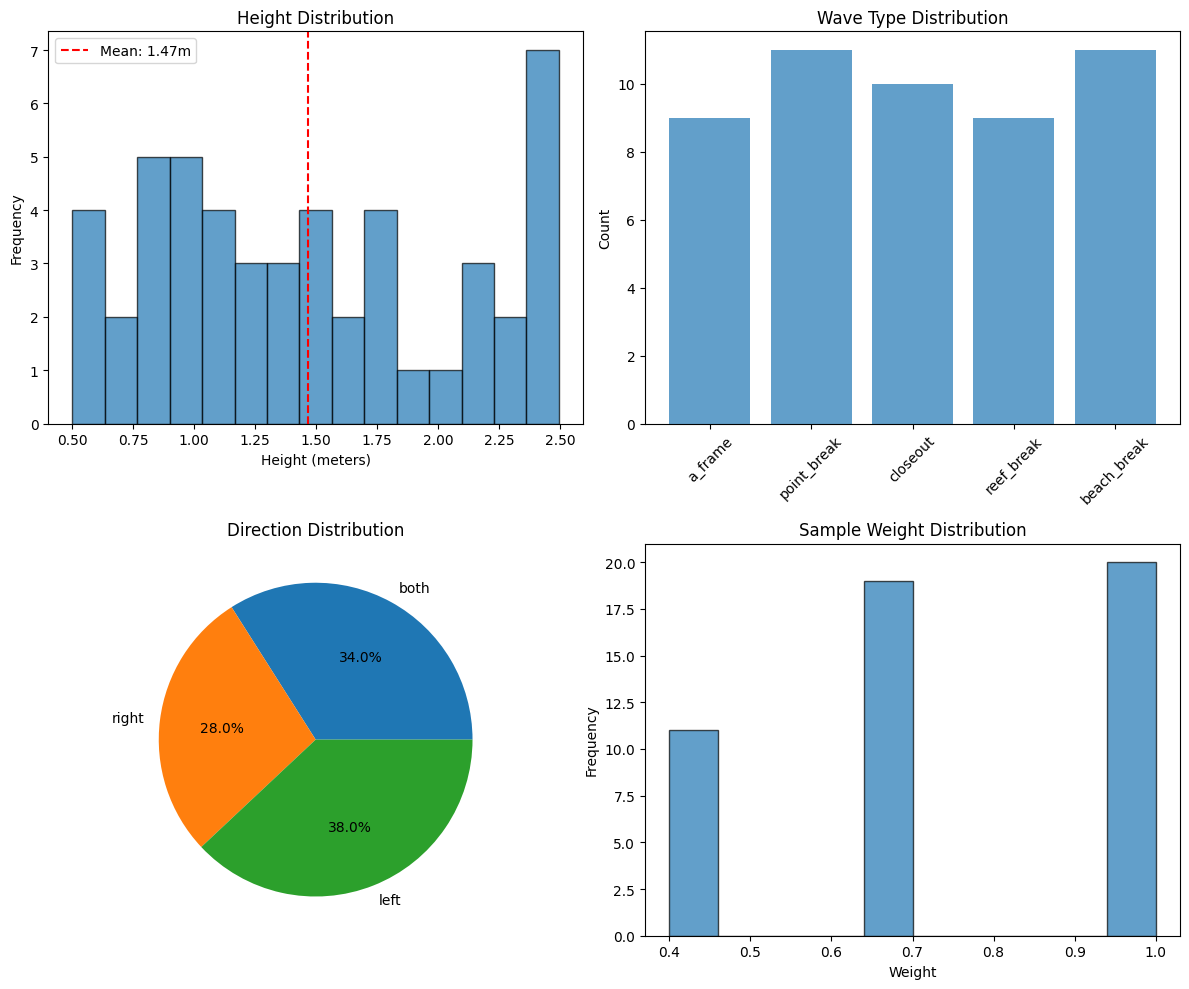


✅ Dataset analysis complete!


In [13]:
# Visualize dataset statistics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Height distribution
axes[0, 0].hist(stats['heights'], bins=15, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Height Distribution')
axes[0, 0].set_xlabel('Height (meters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(stats['heights'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {stats["heights"].mean():.2f}m')
axes[0, 0].legend()

# Wave type distribution
wt_names = list(stats['wave_type_counts'].keys())
wt_counts = list(stats['wave_type_counts'].values())
axes[0, 1].bar(wt_names, wt_counts, alpha=0.7)
axes[0, 1].set_title('Wave Type Distribution')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Direction distribution
dir_names = list(stats['direction_counts'].keys())
dir_counts = list(stats['direction_counts'].values())
axes[1, 0].pie(dir_counts, labels=dir_names, autopct='%1.1f%%')
axes[1, 0].set_title('Direction Distribution')

# Weight distribution
axes[1, 1].hist(stats['weights'], bins=10, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Sample Weight Distribution')
axes[1, 1].set_xlabel('Weight')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\n✅ Dataset analysis complete!")

## Summary

This notebook provides a complete, standalone data loading and processing system for SwellSight:

### ✅ **What we accomplished:**
1. **Utility Functions**: File I/O, directory management, seed setting
2. **Data Transforms**: Training and inference image preprocessing
3. **Dataset Class**: Flexible loading of wave images and labels
4. **Vocabulary Building**: Automatic creation of class mappings
5. **Visualization Tools**: Sample display and dataset analysis
6. **Statistics Analysis**: Comprehensive dataset statistics

### 🔧 **Key Features:**
- **Robust Error Handling**: Graceful fallbacks for missing files
- **Dummy Data Generation**: Works without real dataset files
- **Flexible Transforms**: Configurable augmentation pipelines
- **Confidence Weighting**: Sample importance based on annotation quality
- **Comprehensive Logging**: Clear feedback about data loading

### 📊 **Data Pipeline:**
- **JSONL Format**: Efficient storage of dataset indices
- **Multi-task Labels**: Height (regression) + Type/Direction (classification)
- **Image Preprocessing**: Resize, normalize, augment for training
- **Batch Processing**: Ready for PyTorch DataLoader integration

### 🚀 **Next Steps:**
- Use this dataset class in training notebooks
- Experiment with different augmentation strategies
- Add support for additional data sources (depth maps, etc.)
- Implement custom sampling strategies for imbalanced classes

**This notebook is completely standalone and includes all necessary functionality!**